In [209]:
%load_ext autoreload
%autoreload 2
import sys
# sys.path.append("D:/Github/note/module")                        # for windows
sys.path.append("/Users/xinc./Documents/GitHub/note/module")    # for mac
from get_info_FinMind import GetInfoFinMind
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# function

In [ ]:
def plot(
        df: pd.DataFrame,
        ly: str,                              # 左邊 y 軸資料
        x: str = "index",                     # x 軸的資料
        ry: str | None = None,                # 右邊 y 軸資料
        max_ly: bool = False,                 # 畫左邊 y 最大值
        min_ly: bool = False,                 # 畫左邊 y 最小值
        max_ry: bool = False,                 # 畫右邊 y 最大值
        min_ry: bool = False,                 # 畫右邊 y 最小值
        point_ly: float | None = None,        # 用數值找到左 y 資料位置
        point_ry: float | None = None,        # 用數值找到右 y 資料位置
        point_pct_ly: float | None = None,    # 用百分位數找到左 y 資料位置
        point_pct_ry: float | None = None     # 用百分位數找到左 y 資料位置
):
    if len(df) == 0:
        return {}
    
    # 定義 x 軸
    if x == "index":
        x_vals = pd.Series(
            np.arange(len(df), dtype = float) / max(len(df), 1),
            index = df.index,
            name = "x"
        )
        x_label = "sample proportion"
    else:
        x_vals = df[x]
        x_label = x

    fig, ax1 = plt.subplots(figsize = (16, 5))

    # ----------- 定義 ly 軸 -----------
    left_y = df[ly].astype(float)
    ax1.plot(x_vals, left_y, label = ly, color = "tab:blue")
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(ly, color = "tab:blue")
    ax1.tick_params(axis = "y", labelcolor = "tab:blue")

    mark = {
        "ly_max": None,
        "ly_min": None,
        "ry_max": None,
        "ry_min": None,
        "ly_point": None,
        "ry_point": None
    }

    # 標記 max ly
    if max_ly and len(left_y) > 0:
        max_pos = int(left_y.values.argmax())
        max_idx = left_y.index[max_pos]
        max_x = x_vals.loc[max_idx]
        max_y = left_y.loc[max_idx]
        percent = float(max_x) * 100 if np.issubdtype(type(max_x), np.number) else np.nan,
    
        ax1.scatter(max_x, max_y, color = "black", zorder = 5)

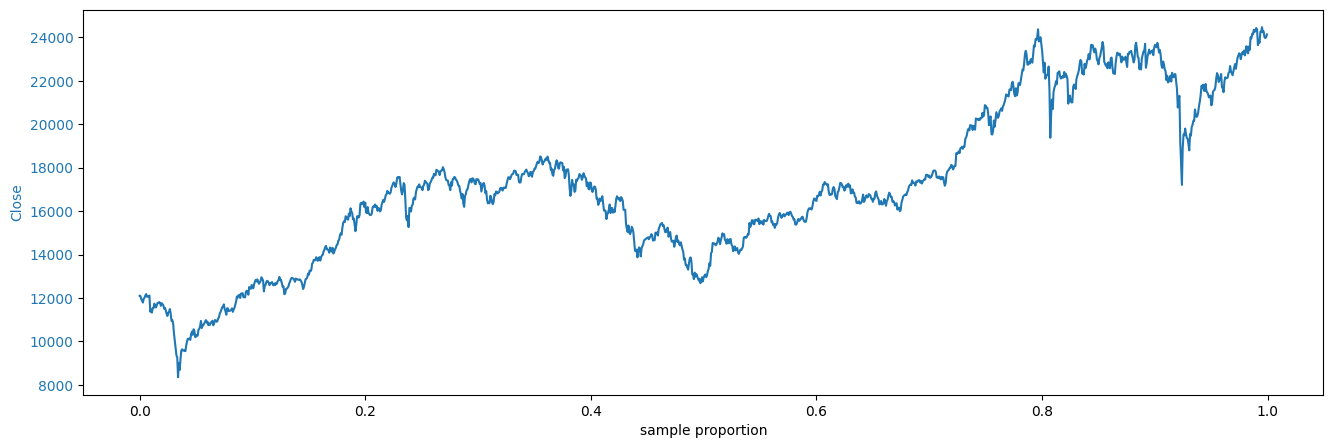

In [144]:
plot(base_df, ly = "Close")

In [200]:
def sorted_plot(
    ratio_sorted_df: pd.DataFrame,
    x: str,
    ly: str,
    ry: str | None = None,
    max_ly: bool = False,
    min_ly: bool = False,
    point_ly: float | None = None,      # 左軸：以「數值」找最近點；也可用 "max"/"min"
    point_ry: float | None = None,      # 右軸：以「數值」找最近點
    point_ly_pct: float | None = None,  # 左軸：以「樣本比例」(0~1 或 0~100) 指定位置
):
    # ---------- 防呆 ----------
    if len(ratio_sorted_df) == 0:
        return {}
    if ly not in ratio_sorted_df.columns:
        raise KeyError(f"{ly} not in DataFrame columns")
    if ry is not None and ry not in ratio_sorted_df.columns:
        raise KeyError(f"{ry} not in DataFrame columns")

    plt.rcParams['font.family'] = 'sans-serif'    # 不設定 font.family，避免字型錯誤

    # ---------- x 座標 ----------
    if x == "index":
        x_vals = pd.Series(
            np.arange(len(ratio_sorted_df), dtype=float) / max(len(ratio_sorted_df), 1),
            index=ratio_sorted_df.index,
            name="x"
        )
        x_label = "sample proportion"
    else:
        x_vals = ratio_sorted_df[x]
        x_label = x

    fig, ax1 = plt.subplots(figsize=(16, 5))

    # ---------- 左軸 ----------
    y_left = ratio_sorted_df[ly].astype(float)
    ax1.plot(x_vals, y_left, label=ly, color="tab:blue")
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(ly, color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    marks = {"ly_max": None, "ly_point": None, "ry_point": None}

    # (A) 標記 ly 最大值
    if max_ly and len(y_left) > 0:
        max_pos = int(y_left.values.argmax())
        max_idx = y_left.index[max_pos]
        max_x = x_vals.loc[max_idx]
        max_y = y_left.loc[max_idx]
        percent = float(max_x) * 100 if np.issubdtype(type(max_x), np.number) else np.nan

        ax1.scatter(max_x, max_y, color="black", zorder=5)
        ax1.axvline(max_x, color="gray", linestyle="--", linewidth=1)
        ax1.annotate(
            f"{ly} max\nidx={max_idx}\ny={max_y:.4f}" + (f"\n({percent:.1f}%)" if np.isfinite(percent) else ""),
            xy=(max_x, max_y),
            xytext=(max_x, max_y + (y_left.abs().max() * 0.05 or 1.0)),
            ha="center",
            fontsize=9, color="black"
        )
        marks["ly_max"] = {
            "index": max_idx,
            "rank": max_pos + 1,
            "proportion": float(max_pos / len(y_left)),
            "x": float(max_x) if np.issubdtype(type(max_x), np.number) else None,
            "y": float(max_y)
        }

    # (A2) 標記 ly 最小值
    if min_ly and len(y_left) > 0:
        min_pos = int(y_left.values.argmin())
        min_idx = y_left.index[min_pos]
        min_x = x_vals.loc[min_idx]
        min_y = y_left.loc[min_idx]
        percent = float(min_x) * 100 if np.issubdtype(type(min_x), np.number) else np.nan

        ax1.scatter(min_x, min_y, color="black", zorder=5)
        ax1.axvline(min_x, color="gray", linestyle="--", linewidth=1)
        ax1.annotate(
            f"{ly} min\nidx={min_idx}\ny={min_y:.4f}" + (f"\n({percent:.1f}%)" if np.isfinite(percent) else ""),
            xy=(min_x, min_y),
            xytext=(min_x, min_y - (y_left.abs().max() * 0.05 or 1.0)),
            ha="center",
            fontsize=9, color="black"
        )
        marks["ly_min"] = {
            "index": min_idx,
            "rank": min_pos + 1,
            "proportion": float(min_pos / len(y_left)),
            "x": float(min_x) if np.issubdtype(type(min_x), np.number) else None,
            "y": float(min_y)
        }

    # (B) 標記 ly 的指定點（數值 or 百分比 or "max"/"min"）
    if point_ly is not None or point_ly_pct is not None:
        if isinstance(point_ly, str):
            if point_ly.lower() == "max":
                pos = int(y_left.values.argmax())
            elif point_ly.lower() == "min":
                pos = int(y_left.values.argmin())
            else:
                raise ValueError('point_ly as string must be "max" or "min"')
        elif point_ly_pct is not None:
            pct = float(point_ly_pct)
            if pct > 1:
                pct /= 100.0
            pct = min(max(pct, 0.0), 1.0)
            pos = int(round(pct * (len(ratio_sorted_df) - 1)))
        else:
            # 用數值找最近
            pos = int((y_left - float(point_ly)).abs().values.argmin())

        ly_idx = y_left.index[pos]
        px = x_vals.loc[ly_idx]
        py = y_left.loc[ly_idx]
        percent = float(pos / len(y_left) * 100.0)

        ax1.scatter(px, py, color="tab:blue", zorder=6)
        ax1.axvline(px, color="tab:blue", linestyle="--", linewidth=1)
        ax1.annotate(
            f"{ly}\nidx={ly_idx}\ny={py:.4f}\n({percent:.1f}%)",
            xy=(px, py),
            xytext=(px, py + (y_left.abs().max() * 0.05 or 1.0)),
            ha="center",
            fontsize=9, color="tab:blue"
        )
        marks["ly_point"] = {
            "index": ly_idx,
            "rank": pos + 1,
            "proportion": float(pos / len(y_left)),
            "x": float(px) if np.issubdtype(type(px), np.number) else None,
            "y": float(py)
        }

    # ---------- 右軸 ----------
    ax2 = None
    if ry:
        y_right = ratio_sorted_df[ry].astype(float)
        ax2 = ax1.twinx()
        ax2.plot(x_vals, y_right, label=ry, color="tab:red", linestyle="--")
        ax2.set_ylabel(ry, color="tab:red")
        ax2.tick_params(axis="y", labelcolor="tab:red")

        if point_ry is not None and len(y_right) > 0:
            pos = int((y_right - float(point_ry)).abs().values.argmin())
            idx_closest = y_right.index[pos]
            px = x_vals.loc[idx_closest]
            py = y_right.loc[idx_closest]
            percent = float(pos / len(y_right) * 100.0)

            ax2.scatter(px, py, color="red", zorder=6)
            ax2.axvline(px, color="red", linestyle="--", linewidth=1)
            ax2.annotate(
                f"{ry}\nidx={idx_closest}\ny={py:.4f}\n({percent:.1f}%)",
                xy=(px, py),
                xytext=(px, py + (y_right.abs().max() * 0.05 or 0.01)),
                ha="center",
                fontsize=9, color="red"
            )
            marks["ry_point"] = {
                "index": idx_closest,
                "rank": pos + 1,
                "proportion": float(pos / len(y_right)),
                "x": float(px) if np.issubdtype(type(px), np.number) else None,
                "y": float(py)
            }

    # ---------- 圖例 ----------
    lines, labels = ax1.get_legend_handles_labels()
    if ax2 is not None:
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc="center left", bbox_to_anchor=(1.05, 0.5))
    else:
        ax1.legend(loc="best")

    fig.text(0.98, 0.01, f"Samples: {len(ratio_sorted_df)}", ha='right', fontsize=12, color="b")

    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return marks

# get data

In [435]:
FinMind_fetcher = GetInfoFinMind()
base_df = FinMind_fetcher.init_df("TX", "2015-01-01", "2025-09-17")
base_df = FinMind_fetcher.get_future_daily_info(trading_session = "position", weekly_group = True, monthly_group = True)
# after_df = FinMind_fetcher.init_df("TX", "2015-01-01", "2025-09-04")
# after_df = FinMind_fetcher.get_future_daily_info(trading_session = "after_market")
base_df.to_csv("TX.csv")
# after_df.to_csv("TX_after.csv")

2025-09-20 17:04:14.294 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanFuturesDaily, data_id: TX
/Users/xinc./Documents/GitHub/note/module/get_info_FinMind.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  """


# 週結算 target: wed

## read

In [479]:
base_df = pd.read_csv("TX.csv", index_col = "Timestamp")
base_df.index = pd.to_datetime(base_df.index, format = "%Y-%m-%d")

base_df

,futures_id,contract_date,weekly_group,monthly_group,Open,High,Low,Close,spread,spread_per,Volume,settlement_price,open_interest,trading_session
Timestamp,,,,,,,,,,,,,,
2015-01-05,TX,201501,2015-01-07,2015-01-21,9238.0,9276.0,9155.0,9252.0,-29.0,-0.31,120487.0,9250.0,63140.0,position
2015-01-06,TX,201501,2015-01-07,2015-01-21,9144.0,9153.0,9017.0,9058.0,-192.0,-2.08,148125.0,9058.0,59897.0,position
2015-01-07,TX,201501,2015-01-07,2015-01-21,9042.0,9092.0,9033.0,9045.0,-13.0,-0.14,93314.0,9044.0,60983.0,position
2015-01-08,TX,201501,2015-01-14,2015-01-21,9116.0,9259.0,9115.0,9257.0,213.0,2.36,131883.0,9256.0,65311.0,position
2015-01-09,TX,201501,2015-01-14,2015-01-21,9328.0,9335.0,9217.0,9230.0,-26.0,-0.28,117874.0,9230.0,61302.0,position
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-11,TX,202509,2025-09-17,2025-09-17,25386.0,25464.0,25176.0,25240.0,64.0,0.25,73339.0,25233.0,80304.0,position
2025-09-12,TX,202509,2025-09-17,2025-09-17,25418.0,25466.0,25350.0,25459.0,226.0,0.90,55444.0,25458.0,73194.0,position
2025-09-15,TX,202509,2025-09-17,2025-09-17,25404.0,25450.0,25269.0,25353.0,-105.0,-0.41,89375.0,25347.0,40730.0,position


## sum 跳空 ret

In [490]:
operate_df = pd.DataFrame()

temp_df = base_df.copy()
temp_df["cross_daily_ret"] = (temp_df["Open"] / temp_df["Close"].shift(1)) - 1


# t - 1 週 ret sumation
operate_df["sum_cross_ret"] = temp_df.groupby("weekly_group")["cross_daily_ret"].sum()

# t 週結算日報酬
operate_df["wed_ret"] = (temp_df["Close"] / temp_df["Open"]) - 1

# fill wed_ret NaN 順延下一個交易日
nan_idx = operate_df[operate_df["wed_ret"].isna()].index
for t in nan_idx:
    next_idx = temp_df.index[temp_df.index > t]
    next_date = next_idx[0] if len(next_idx) > 0 else None
    next_date = pd.to_datetime(next_date, format = "%Y-%m-%d") if next_date is not None else None
    ret = (temp_df.loc[next_date, "Close"] / temp_df.loc[next_date, "Open"]) - 1 if next_date is not None else np.nan
    operate_df.loc[t, "wed_ret"] = ret


# demeaning
mean = operate_df["wed_ret"].mean()
operate_df["demeaned_wed_ret"] = operate_df["wed_ret"] - mean
operate_df.to_csv("test.csv")

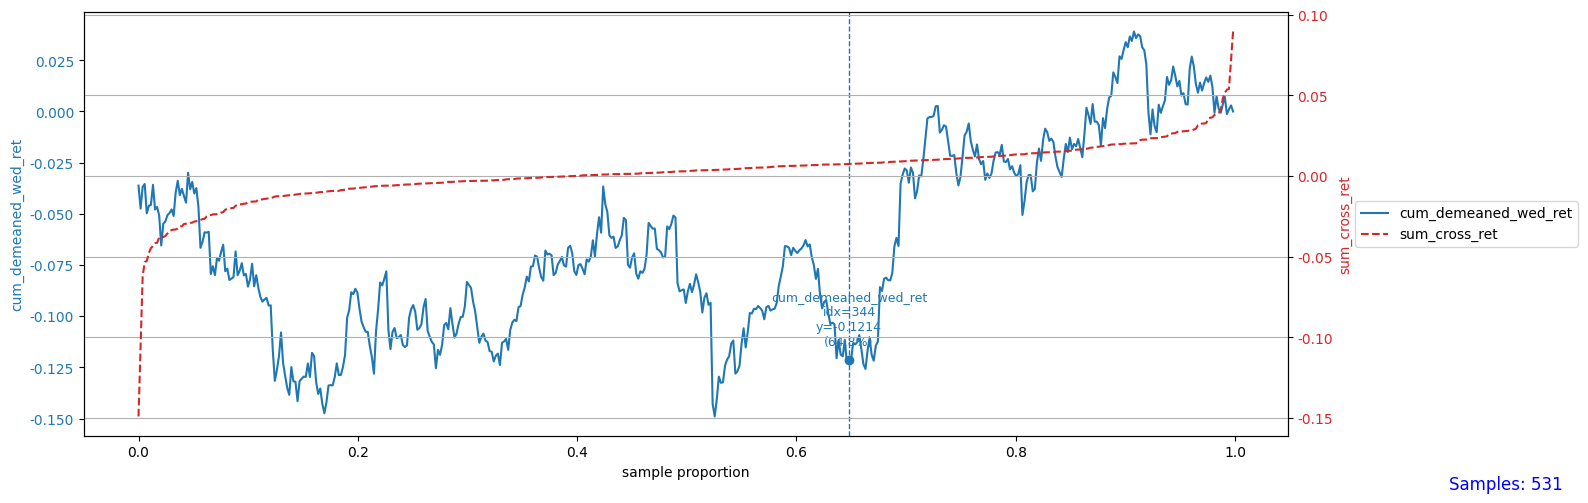

{'ly_max': None,
 'ly_point': {'index': 344,
  'rank': 345,
  'proportion': 0.647834274952919,
  'x': 0.647834274952919,
  'y': -0.12141591410463312},
 'ry_point': None}

In [491]:
"""sort & cumsum"""

operate_df.sort_values("sum_cross_ret", inplace = True)
operate_df.reset_index(drop = False, inplace = True)
operate_df["cum_demeaned_wed_ret"] = operate_df["demeaned_wed_ret"].cumsum()

sorted_plot(operate_df, "index", ly = "cum_demeaned_wed_ret", ry = "sum_cross_ret", point_ly_pct = 0.65)
# right idx: 344

In [492]:
"""seperate df & calculate mean"""
right_df = operate_df[344: ]
right_mean = right_df["demeaned_wed_ret"].mean()
print(f"right mean: {right_mean:.6f}")

right mean: 0.000657


## (main)! thu_open ~ wed_open, log +

In [544]:
operate_df = pd.DataFrame()

temp_df = base_df.copy()

# t - 1 月 ret
first_open = temp_df.groupby("weekly_group")["Open"].first()
settle_open = temp_df.groupby("weekly_group")["Open"].last()
operate_df["weekly_ret"] = (settle_open / first_open) - 1

# t 週結算日 ret
operate_df["wed_ret"] = (temp_df["Close"] / temp_df["Open"]) - 1

# demeaning
mean = operate_df["wed_ret"].mean()
operate_df["demeaned_wed_ret"] = operate_df["wed_ret"] - mean

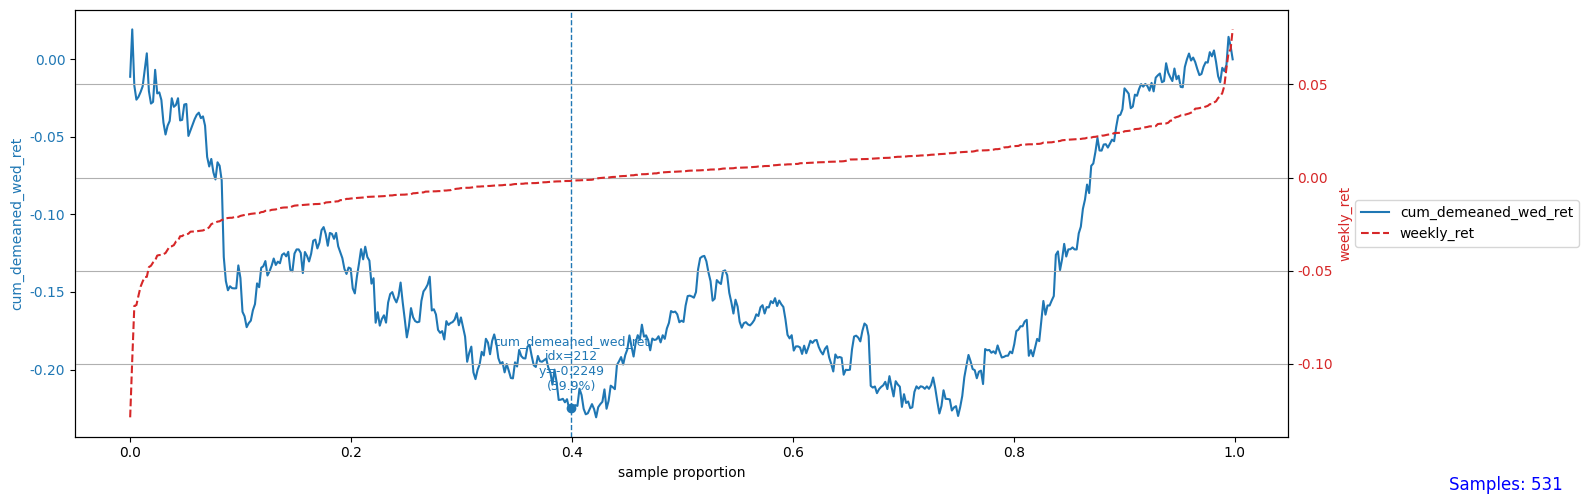

{'ly_max': None,
 'ly_point': {'index': 212,
  'rank': 213,
  'proportion': 0.3992467043314501,
  'x': 0.3992467043314501,
  'y': -0.22488013925044095},
 'ry_point': None}

In [545]:
"""sort & cumsum"""

operate_df.sort_values("weekly_ret", inplace = True)
operate_df.reset_index(drop = False, inplace = True)
operate_df["cum_demeaned_wed_ret"] = operate_df["demeaned_wed_ret"].cumsum()

sorted_plot(operate_df, "index", ly = "cum_demeaned_wed_ret", ry = "weekly_ret", point_ly_pct = 0.4)
# 兩個底的idx: 212(0.4), 398(0.75)

In [546]:
# seperate df
left_df = operate_df[: 212]
right_df = operate_df[398: ]

# calculate mean
left_mean, right_mean = left_df["demeaned_wed_ret"].mean(), right_df["demeaned_wed_ret"].mean()

print(f"left mean: {left_mean:.6f}, right mean: {right_mean:.6f}")

left mean: -0.001062, right mean: 0.001681


### add filter 跳空

In [540]:
# get previous idx
all_idx = temp_df.index
target_idx = operate_df.index
pos = np.searchsorted(all_idx, target_idx)
prev_idx = all_idx[pos - 1]

# calculate gap
gap = (temp_df["Open"].iloc[pos].values / temp_df["Close"].iloc[pos - 1].values) - 1
operate_df.sort_index(inplace = True)
operate_df["gap"] = gap

# resort operate
operate_df.sort_values("weekly_ret", inplace = True)

# seperate df
left_df = operate_df[: 212].copy()
right_df = operate_df[398: ].copy()

# sort by gap
left_df = left_df.sort_values("gap").reset_index(drop = False)
right_df = right_df.sort_values("gap").reset_index(drop = False)

# cumsum
left_df["cum_demeaned_wed_ret"] = left_df["demeaned_wed_ret"].cumsum()
right_df["cum_demeaned_wed_ret"] = right_df["demeaned_wed_ret"].cumsum()

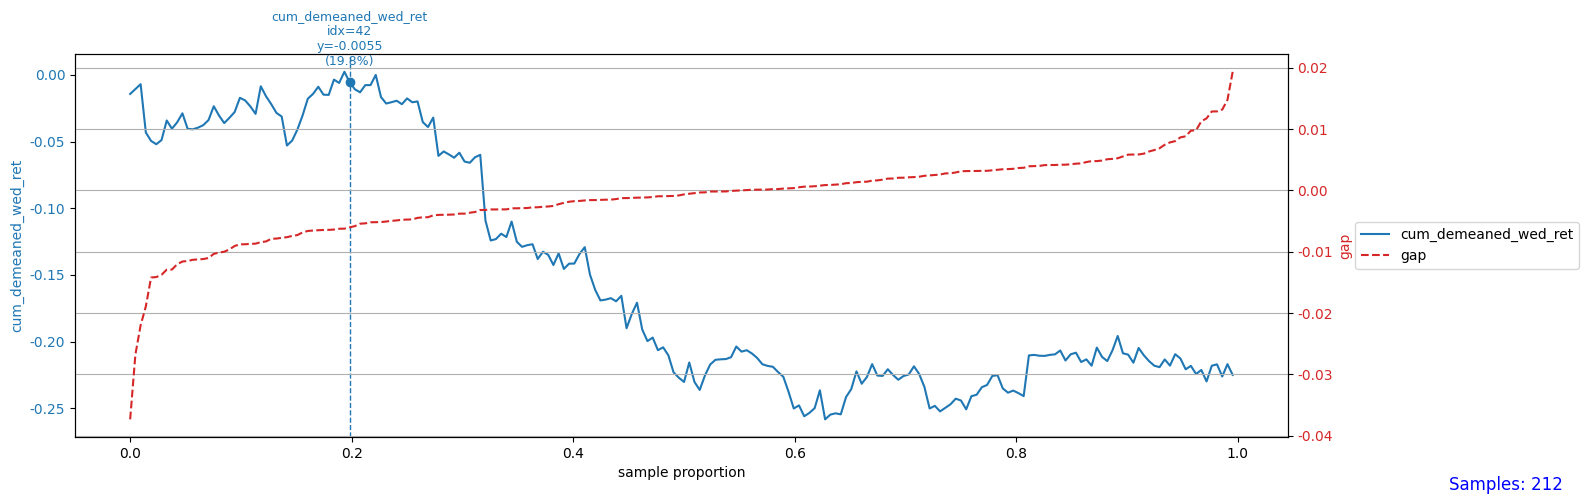

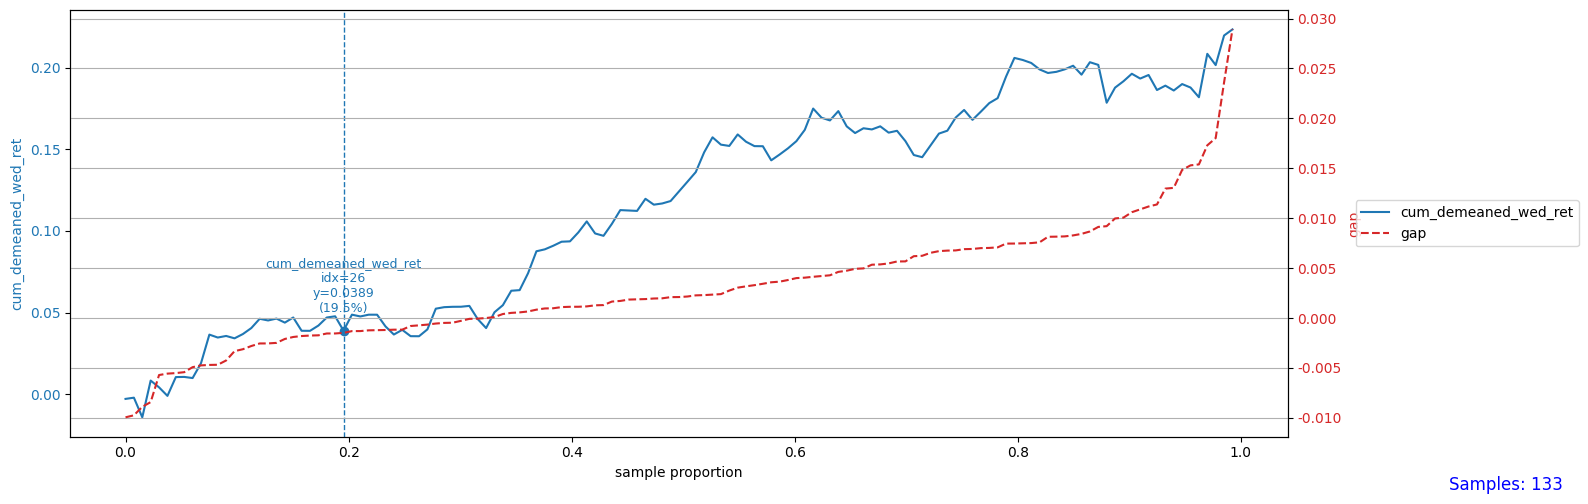

{'ly_max': None,
 'ly_point': {'index': 26,
  'rank': 27,
  'proportion': 0.19548872180451127,
  'x': 0.19548872180451127,
  'y': 0.0388731128009393},
 'ry_point': None}

In [ ]:
sorted_plot(left_df, "index", ly = "cum_demeaned_wed_ret", ry = "gap", point_ly_pct = 0.2)
sorted_plot(right_df, "index", ly = "cum_demeaned_wed_ret", ry = "gap", point_ly_pct = 0.2)

# filter left_df, 42: 127
# filter right_df, all

In [556]:
filtered_left_df = left_df[: 127]
filtered_right_df = right_df

filtered_mean_left = filtered_left_df["demeaned_wed_ret"].mean()
filtered_mean_right = filtered_right_df["demeaned_wed_ret"].mean()
print(f"filtered left mean: {filtered_mean_left:.6f}, filtered right mean: {filtered_mean_right:.6f}")

filtered left mean: -0.001182, filtered right mean: 0.001681


# 月結算 target: wed

## read

In [280]:
base_df = pd.read_csv("TX.csv", index_col = "Timestamp")
base_df.index = pd.to_datetime(base_df.index, format = "%Y-%m-%d")

## sum 跳空 ret

In [439]:
operate_df = pd.DataFrame()

temp_df = base_df.copy()
temp_df["cross_daily_ret"] = (temp_df["Open"] / temp_df["Close"].shift(1)) - 1

# t - 1 月 ret sum
operate_df["sum_cross_ret"] = temp_df.groupby("monthly_group")["cross_daily_ret"].sum()

# t 週結算日 ret
operate_df["wed_ret"] = (temp_df["Close"] / temp_df["Open"]) - 1

# fill wed_ret NaN 順延下一個交易日
nan_idx = operate_df[operate_df["wed_ret"].isna()].index
for t in nan_idx:
    next_idx = temp_df.index[temp_df.index > t]
    next_date = next_idx[0] if len(next_idx) > 0 else None
    next_date = pd.to_datetime(next_date, format = "%Y-%m-%d") if next_date is not None else None
    ret = (temp_df.loc[next_date, "Close"] / temp_df.loc[next_date, "Open"]) - 1 if next_date is not None else np.nan
    operate_df.loc[t, "wed_ret"] = ret

# demeaning
mean = operate_df["wed_ret"].mean()
operate_df["demeaned_wed_ret"] = operate_df["wed_ret"] - mean
operate_df.to_csv("test.csv")

In [440]:
"""sort & cumsum"""

operate_df.sort_values("sum_cross_ret", inplace = True)
operate_df.reset_index(drop = False, inplace = True)
operate_df["cum_demeaned_wed_ret"] = operate_df["demeaned_wed_ret"].cumsum()
operate_df

,monthly_group,sum_cross_ret,wed_ret,demeaned_wed_ret,cum_demeaned_wed_ret
0,2020-03-18,-0.190440,-0.010997,-0.010433,-1.043259e-02
1,2025-04-16,-0.071927,-0.002704,-0.002139,-1.257190e-02
2,2025-03-19,-0.071098,-0.012321,-0.011757,-2.432852e-02
3,2019-08-21,-0.067328,0.001332,0.001896,-2.243233e-02
4,2022-09-21,-0.065756,-0.005112,-0.004547,-2.697960e-02
...,...,...,...,...,...
124,2025-09-17,0.071574,-0.004813,-0.004248,7.350262e-03
125,2023-01-30,0.074094,-0.006877,-0.006313,1.037405e-03
126,2022-11-16,0.087433,-0.008276,-0.007712,-6.674295e-03
127,2020-08-19,0.089460,-0.007671,-0.007107,-1.378111e-02


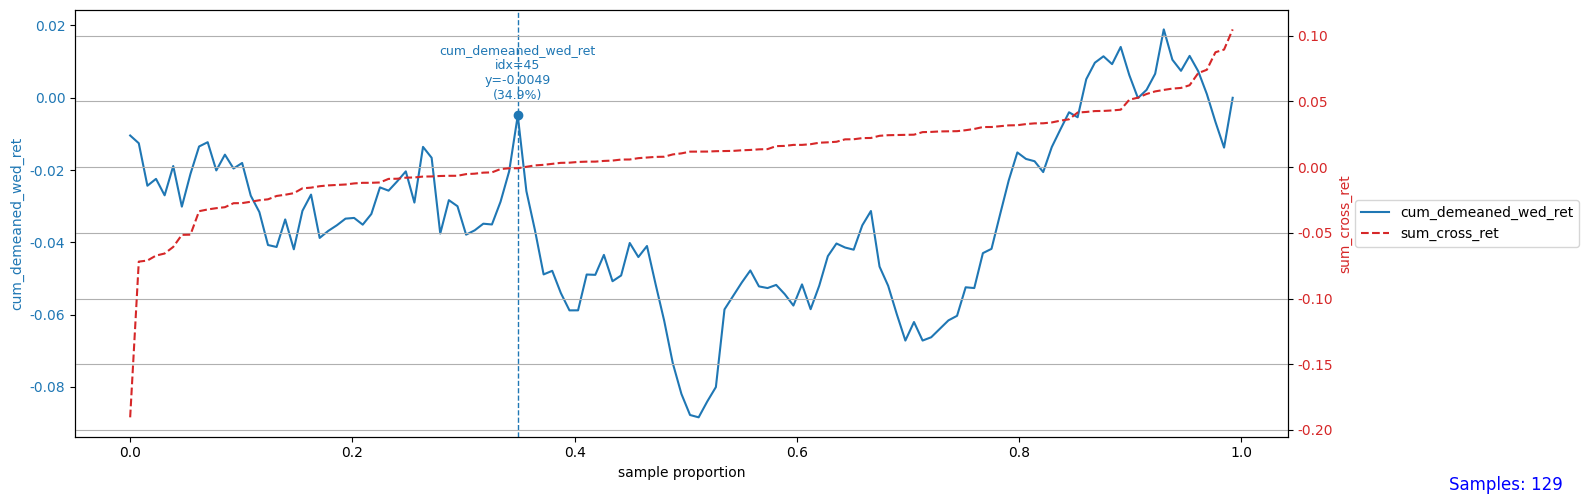

{'ly_max': None,
 'ly_point': {'index': 45,
  'rank': 46,
  'proportion': 0.3488372093023256,
  'x': 0.3488372093023256,
  'y': -0.004889899158323118},
 'ry_point': None}

In [441]:
sorted_plot(operate_df, "index", ly = "cum_demeaned_wed_ret", ry = "sum_cross_ret", point_ly_pct = 0.35)

## thu_open ~ wed_open log +

In [323]:
operate_df = pd.DataFrame()

temp_df = base_df.copy()

# t - 1 月 ret
first_open = temp_df.groupby("monthly_group")["Open"].first()
settle_open = temp_df.groupby("monthly_group")["Open"].last()
operate_df["monthly_ret"] = (settle_open / first_open) - 1

# t 週結算日 ret
operate_df["wed_ret"] = (temp_df["Close"] / temp_df["Open"]) - 1

# fill wed_ret NaN 順延下一個交易日
nan_idx = operate_df[operate_df["wed_ret"].isna()].index
for t in nan_idx:
    next_idx = temp_df.index[temp_df.index > t]
    next_date = next_idx[0] if len(next_idx) > 0 else None
    next_date = pd.to_datetime(next_date, format = "%Y-%m-%d") if next_date is not None else None
    ret = (temp_df.loc[next_date, "Close"] / temp_df.loc[next_date, "Open"]) - 1 if next_date is not None else np.nan
    operate_df.loc[t, "wed_ret"] = ret

# demeaning
mean = operate_df["wed_ret"].mean()
operate_df["demeaned_wed_ret"] = operate_df["wed_ret"] - mean

In [325]:
"""sort & cumsum"""

operate_df.sort_values("monthly_ret", inplace = True)
operate_df.reset_index(drop = False, inplace = True)
operate_df["cum_demeaned_wed_ret"] = operate_df["demeaned_wed_ret"].cumsum()

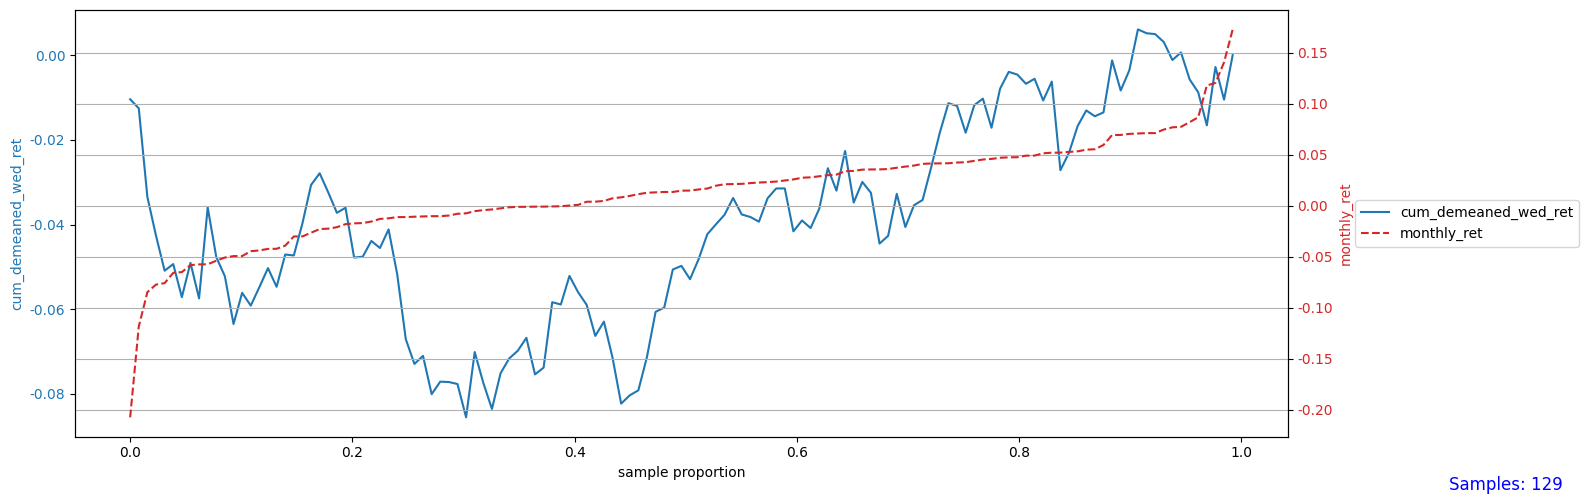

{'ly_max': None, 'ly_point': None, 'ry_point': None}

In [326]:
sorted_plot(operate_df, "index", ly = "cum_demeaned_wed_ret", ry = "monthly_ret")

# 週結算 target: thu

## read

In [436]:
base_df = pd.read_csv("TX.csv", index_col = "Timestamp")
base_df.index = pd.to_datetime(base_df.index, format = "%Y-%m-%d")

## sum t - 1 週 ret, target: thu ret

In [468]:
operate_df = pd.DataFrame()

# 算 ret
temp_df = base_df.copy()
temp_df["daily_ret"] = (temp_df["Close"] / temp_df["Open"]) - 1

# t - 1 週報酬
operate_df["sum_ret"] = temp_df.groupby("weekly_group")["daily_ret"].sum().rename("sum_ret")
operate_df = operate_df[: -1]
operate_df.index = pd.to_datetime(operate_df.index, format = "%Y-%m-%d")

# get thu index
all_date = temp_df.index
settle_date = list(temp_df["weekly_group"].unique())
target_pos = all_date.searchsorted(settle_date, side = "right")
target_pos = target_pos[: -1]

# t 週第一跟根報酬
thu_ret = (temp_df["Close"].iloc[target_pos] / temp_df["Open"].iloc[target_pos]) - 1
operate_df["thu_ret"] = thu_ret.values

# demeaning
mean = operate_df["thu_ret"].mean()
operate_df["demeaned_thu_ret"] = operate_df["thu_ret"] - mean
operate_df

,sum_ret,thu_ret,demeaned_thu_ret
weekly_group,,,
2015-01-07,-0.007558,0.015467,0.015632
2015-01-14,0.003469,0.000871,0.001036
2015-01-21,-0.000918,0.002991,0.003156
2015-01-28,0.010701,-0.007265,-0.007101
2015-02-04,-0.007758,-0.000735,-0.000570
...,...,...,...
2025-08-13,0.017422,-0.003575,-0.003410
2025-08-20,-0.016003,0.005184,0.005348
2025-08-27,0.014493,-0.005337,-0.005172


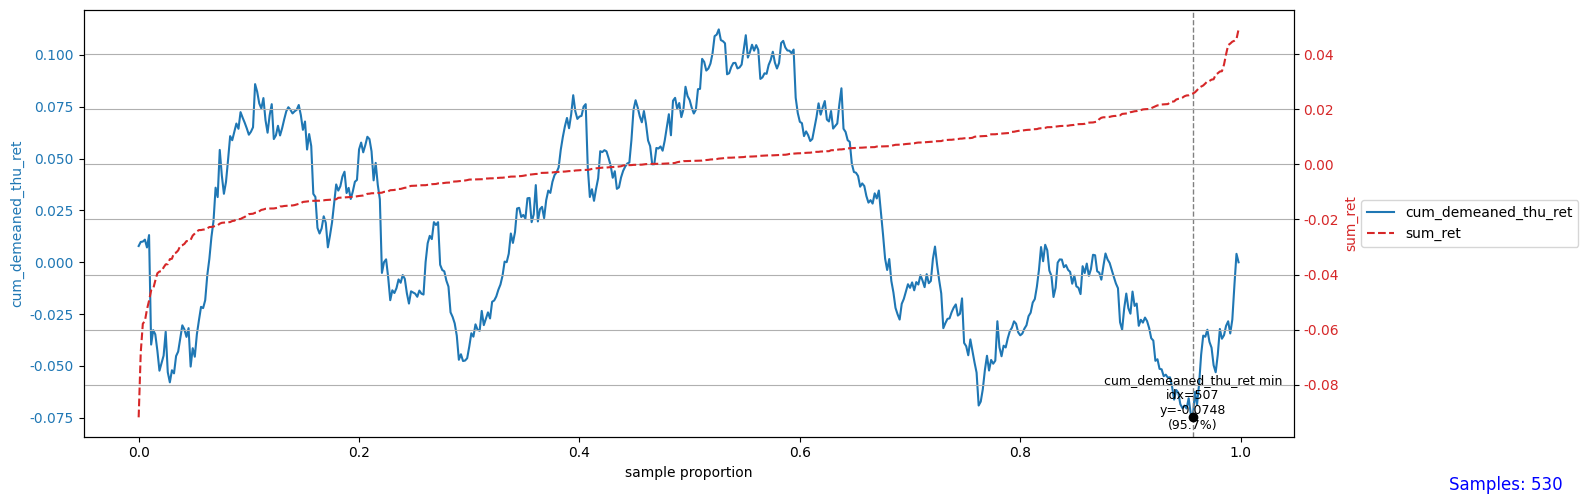

{'ly_max': None,
 'ly_point': None,
 'ry_point': None,
 'ly_min': {'index': 507,
  'rank': 508,
  'proportion': 0.9566037735849057,
  'x': 0.9566037735849057,
  'y': -0.0747519579359811}}

In [473]:
"""sort, cumsum & plot"""
operate_df.sort_values("sum_ret", inplace = True)
operate_df.reset_index(drop = False, inplace = True)
operate_df["cum_demeaned_thu_ret"] = operate_df["demeaned_thu_ret"].cumsum()

sorted_plot(operate_df, "index", ly = "cum_demeaned_thu_ret", ry = "sum_ret", min_ly = True)

## sum 跳空

In [463]:
operate_df = pd.DataFrame()

temp_df = base_df.copy()
temp_df["cross_daily_ret"] = (temp_df["Open"].shift(-1) / temp_df["Close"]) - 1

# t - 1 週 ret sumation
operate_df["sum_cross_ret"] = temp_df.groupby("weekly_group")["cross_daily_ret"].sum()
operate_df = operate_df[: -1]

# 抓到結算隔天的idx
all_date = temp_df.index
settle_date = list(temp_df["weekly_group"].unique())
target_pos = all_date.searchsorted(settle_date, side = "right")
target_pos = target_pos[: -1]

# get target ret
thu_ret = (temp_df["Close"].iloc[target_pos] / temp_df["Open"].iloc[target_pos]) - 1
operate_df["thu_ret"] = thu_ret.values

# demeaning
mean = operate_df["thu_ret"].mean()
operate_df["demeaned_thu_ret"] = operate_df["thu_ret"] - mean
operate_df

,sum_cross_ret,thu_ret,demeaned_thu_ret
weekly_group,,,
2015-01-07,-0.005590,0.015467,0.015632
2015-01-14,0.004547,0.000871,0.001036
2015-01-21,0.019702,0.002991,0.003156
2015-01-28,0.003909,-0.007265,-0.007101
2015-02-04,0.010368,-0.000735,-0.000570
...,...,...,...
2025-08-13,0.010973,-0.003575,-0.003410
2025-08-20,-0.008960,0.005184,0.005348
2025-08-27,0.011881,-0.005337,-0.005172


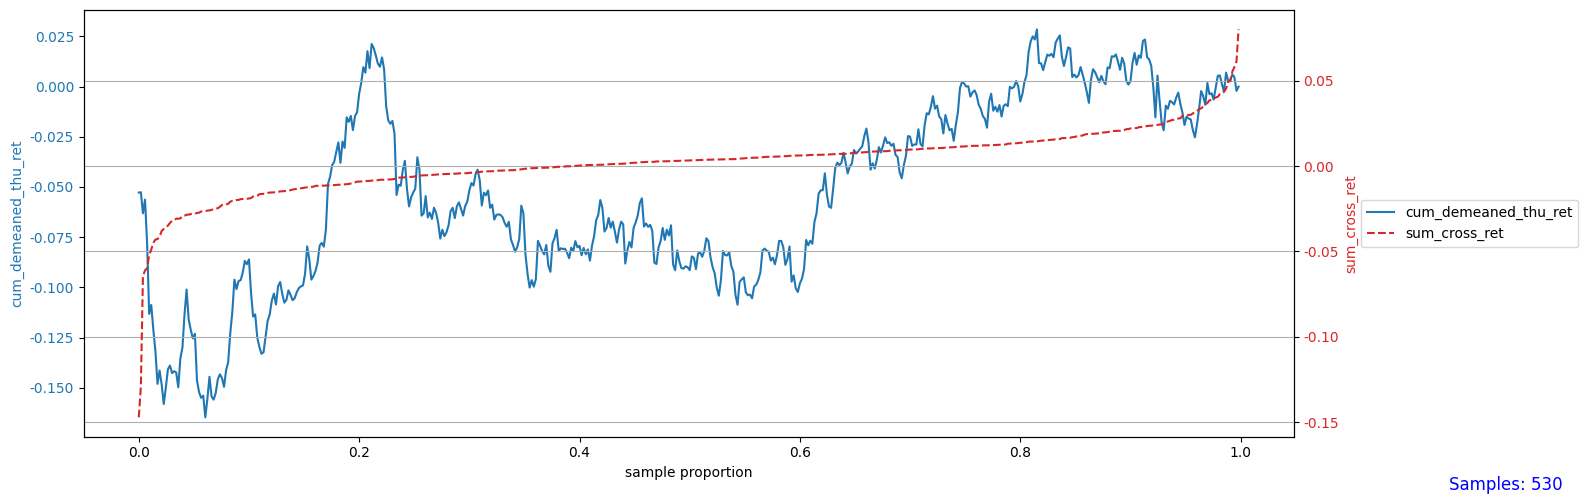

{'ly_max': None, 'ly_point': None, 'ry_point': None}

In [464]:
"""sort & cumsum & plot"""

operate_df.sort_values("sum_cross_ret", inplace = True)
operate_df.reset_index(drop = False, inplace = True)
operate_df["cum_demeaned_thu_ret"] = operate_df["demeaned_thu_ret"].cumsum()

sorted_plot(operate_df, "index", ly = "cum_demeaned_thu_ret", ry = "sum_cross_ret")

# 月結算 target: thu